### Loading the Libraries

In [1]:
import os
import json
import requests
import urllib
import webbrowser

In [2]:
import string

In [60]:
from collections import Counter

In [2]:
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
import tweepy

In [4]:
import pandas as pd
import numpy as np

In [111]:
import matplotlib.pyplot as plt

In [3]:
from requests_oauthlib import OAuth1
from dotenv import load_dotenv, find_dotenv

In [1]:
from pymongo import MongoClient

In [13]:
from bs4 import BeautifulSoup as bs

In [48]:
from nltk.tokenize import TweetTokenizer

from nltk.corpus import stopwords

In [32]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [4]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict

In [17]:
from zipfile import ZipFile 

from nltk.tag import StanfordNERTagger

## Functions

In [16]:
# string of list of strings to list and then join it
def str_lst(sent):
    return "".join([x for x in list(sent) if x not in string.punctuation])

### Global Variables

In [27]:
## Setting the path to java.exe for nltk
java_path = "F:/java/java/bin/java.exe"
    
os.environ['JAVAHOME'] = java_path

In [5]:
folder_path = os.path.expanduser('../data/')  
load_dotenv(os.path.join(folder_path, '.env'))

True

In [6]:
consumer_key = os.environ.get("TWITTER_API_KEY")
consumer_secret = os.environ.get("TWITTER_API_SECRET")

In [7]:
callback_URL = "oob"

## Getting Data

In [ ]:
## Variables
# url's
url = "https://api.Twitter.com/1.1/search/tweets.json"

# parameters
qry = "premier league -filter:retweets AND -filter:replies"
pms = {"q" : qry, "count" : 100, "lang" : "en", 
       "result_type": "recent"}

In [8]:
## ----- AUTHORIZATION -----

oauth = tweepy.OAuthHandler(consumer_key, consumer_secret, callback_URL)

redirect_URL = auth.get_authorization_url()

In [9]:
webbrowser.open(redirect_URL)

True

In [10]:
PIN = input("Enter the PIN :")

Enter the PIN :7773699


In [11]:
access_token, access_secret = auth.get_access_token(PIN)

In [13]:
## --- REST API ---
# getting data 
auth = OAuth1(consumer_key, consumer_secret, access_token, access_secret)

res = requests.get(url, params = pms, auth=auth)

In [15]:
tweets = res.json()

In [20]:
# tweets["statuses"][5]
# tweets.keys()

# for status in tweets["statuses"]:
#     print(status["text"])
#     print("--------------------------------")

In [3]:
## --- Connecting to  Mongo db ---
client = MongoClient("mongodb://127.0.0.1:27017/")

In [4]:
db = client["Tweets"]
collection = db["saved"]

In [25]:
## --- Paginating Twitter API ---
pages_counter = 0
no_of_pages = 100

while pages_counter < no_of_pages:
    pages_counter +=1
    res = requests.get(url, params=pms, auth=auth)
    print(f"Connection status : {res.reason}")
    tweets = res.json()
    ids = [status["id"] for status in tweets["statuses"]]
    pms["max_id"] = min(ids) - 1
    collection.insert_many(tweets["statuses"])

Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection status : OK
Connection 

##  Cleaning data

In [7]:
## Converting tweets data to Pandas DataFrame
docs = []

for doc in collection.find():
    docs.append(doc)
    
df = pd.DataFrame(docs)

In [14]:
# df.head()
# df.source

In [15]:
## Cleaning the source from html to human readable text
df["tweet_source"] = df['source'].apply(lambda x:bs(x).get_text())

In [19]:
# df.tweet_source

In [21]:
## getting all the devices 
devices = list(set(df[df["tweet_source"].str.startswith("Twitter")]["tweet_source"]))

devices

['Twitter for Yids',
 'Twitter Media Studio - LiveCut',
 'Twitter Media Studio',
 'Twitter for Advertisers',
 'TwitterRSSTSOLAgent',
 'Twitter for iPad',
 'Twitter for Muppets',
 'Twitter for Mac',
 'Twitter Web Client',
 'Twitter for Android',
 'Twitter for Advertisers (legacy)',
 'Twitter for iPhone',
 'Twitter Ads',
 'Twitter Web App']

In [26]:
# devices.remove("Twitter for Advertisers")

# devices.remove("Twitter for Advertisers (legacy)")

In [27]:
devices

['Twitter for Yids',
 'Twitter Media Studio - LiveCut',
 'Twitter Media Studio',
 'TwitterRSSTSOLAgent',
 'Twitter for iPad',
 'Twitter for Muppets',
 'Twitter for Mac',
 'Twitter Web Client',
 'Twitter for Android',
 'Twitter for iPhone',
 'Twitter Ads',
 'Twitter Web App']

In [28]:
df = df[df["tweet_source"].isin(devices)]

df.head()

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,favorited,retweeted,possibly_sensitive,lang,extended_entities,quoted_status_id,quoted_status_id_str,quoted_status,withheld_in_countries,tweet_source
0,5fd399c6cfd91d1e0c13b696,Fri Dec 11 16:09:39 +0000 2020,1337429349767712768,1337429349767712768,Alisson Becker &amp; Alex Oxlade-Chamberlain H...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",None,...,False,False,False,en,NaN,NaN,NaN,NaN,NaN,Twitter Web App
1,5fd399c6cfd91d1e0c13b697,Fri Dec 11 16:09:38 +0000 2020,1337429344348762112,1337429344348762112,EPL TONIGHT \n\nLeeds and West Ham both hope t...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",None,...,False,False,False,en,NaN,NaN,NaN,NaN,NaN,Twitter for Android
3,5fd399c6cfd91d1e0c13b699,Fri Dec 11 16:08:44 +0000 2020,1337429118821003266,1337429118821003266,Bruno Fernandes has won more Premier League PO...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",None,...,False,False,False,en,NaN,NaN,NaN,NaN,NaN,Twitter for iPhone
4,5fd399c6cfd91d1e0c13b69a,Fri Dec 11 16:08:35 +0000 2020,1337429081038741507,1337429081038741507,I have seen a lot of negative comments on Mesl...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",None,...,False,False,NaN,en,NaN,NaN,NaN,NaN,NaN,Twitter Web App
6,5fd399c6cfd91d1e0c13b69c,Fri Dec 11 16:08:21 +0000 2020,1337429020258942976,1337429020258942976,Jose Mourinho is the Premier League manager of...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",None,...,False,False,False,en,NaN,NaN,NaN,NaN,NaN,Twitter for Android


In [23]:
df.shape

(6506, 37)

In [21]:
## Gettign tweets of England 
tmp_str = "Ghana|ghana|jamaica|Jamaica|Ladbrokes|India|Pakistan|Ghana Prmier League|Vijay|Predictipons|Eygptian Premier League|cricket|Kings|Carrabbean Premier League|@cricbuzz|Cricinfo"

df = df[~df.text.str.contains(tmp_str)]

In [24]:
# df.shape

In [26]:
## Text Normalization
# tokenizing the tweets
df["tokens"] = df["text"].apply(TweetTokenizer().tokenize)

In [49]:
# removing stopwords
stop_words = stopwords.words("english")
df["stopwords"] = df["tokens"].apply(lambda x:[i for i in x if i.lower() not in stop_words])

In [58]:
# removing special chars
puncs = list(string.punctuation)
digits  =list(string.digits)

df["punctuations"] = df["stopwords"].apply(lambda x : [i for i in x if i not in puncs])

df["digits"] = df["punctuations"].apply(lambda x : [i for i in x if i[0] not in digits])

df["final"] = df["digits"].apply(lambda x : [i for i in x if len(i) > 1])

In [59]:
df.to_csv("../data/tweets.csv")

## Sentimental Anlaysis

In [82]:
df = pd.read_csv("../data/tweets.csv")

df = df.drop(df.columns[0], axis=1)

df.head()

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,quoted_status_id,quoted_status_id_str,quoted_status,withheld_in_countries,tweet_source,tokens,stopwords,punctuations,digits,final
0,5fd399c6cfd91d1e0c13b696,Fri Dec 11 16:09:39 +0000 2020,1337429349767712768,1337429349767712768,Alisson Becker &amp; Alex Oxlade-Chamberlain H...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,NaN,NaN,NaN,NaN,Twitter Web App,"['Alisson', 'Becker', '&', 'Alex', 'Oxlade-Cha...","['Alisson', 'Becker', '&', 'Alex', 'Oxlade-Cha...","['Alisson', 'Becker', 'Alex', 'Oxlade-Chamberl...","['Alisson', 'Becker', 'Alex', 'Oxlade-Chamberl...","['Alisson', 'Becker', 'Alex', 'Oxlade-Chamberl..."
1,5fd399c6cfd91d1e0c13b697,Fri Dec 11 16:09:38 +0000 2020,1337429344348762112,1337429344348762112,EPL TONIGHT \n\nLeeds and West Ham both hope t...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,NaN,NaN,NaN,NaN,Twitter for Android,"['EPL', 'TONIGHT', 'Leeds', 'and', 'West', 'Ha...","['EPL', 'TONIGHT', 'Leeds', 'West', 'Ham', 'ho...","['EPL', 'TONIGHT', 'Leeds', 'West', 'Ham', 'ho...","['EPL', 'TONIGHT', 'Leeds', 'West', 'Ham', 'ho...","['EPL', 'TONIGHT', 'Leeds', 'West', 'Ham', 'ho..."
2,5fd399c6cfd91d1e0c13b699,Fri Dec 11 16:08:44 +0000 2020,1337429118821003266,1337429118821003266,Bruno Fernandes has won more Premier League PO...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,NaN,NaN,NaN,NaN,Twitter for iPhone,"['Bruno', 'Fernandes', 'has', 'won', 'more', '...","['Bruno', 'Fernandes', 'Premier', 'League', 'P...","['Bruno', 'Fernandes', 'Premier', 'League', 'P...","['Bruno', 'Fernandes', 'Premier', 'League', 'P...","['Bruno', 'Fernandes', 'Premier', 'League', 'P..."
3,5fd399c6cfd91d1e0c13b69a,Fri Dec 11 16:08:35 +0000 2020,1337429081038741507,1337429081038741507,I have seen a lot of negative comments on Mesl...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,NaN,NaN,NaN,NaN,Twitter Web App,"['I', 'have', 'seen', 'a', 'lot', 'of', 'negat...","['seen', 'lot', 'negative', 'comments', 'Mesli...","['seen', 'lot', 'negative', 'comments', 'Mesli...","['seen', 'lot', 'negative', 'comments', 'Mesli...","['seen', 'lot', 'negative', 'comments', 'Mesli..."
4,5fd399c6cfd91d1e0c13b69c,Fri Dec 11 16:08:21 +0000 2020,1337429020258942976,1337429020258942976,Jose Mourinho is the Premier League manager of...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,NaN,NaN,NaN,NaN,Twitter for Android,"['Jose', 'Mourinho', 'is', 'the', 'Premier', '...","['Jose', 'Mourinho', 'Premier', 'League', 'man...","['Jose', 'Mourinho', 'Premier', 'League', 'man...","['Jose', 'Mourinho', 'Premier', 'League', 'man...","['Jose', 'Mourinho', 'Premier', 'League', 'man..."


In [106]:
# converting string of list of strings to list and join them 
df["text_cleaned"] = df["final"].apply(str_lst)

In [33]:
# creating a sentiment object
sentiment = SentimentIntensityAnalyzer()

In [34]:
# determine the polarity scores
df["sentiment"] = df.text.apply(lambda x : sentiment.polarity_scores(x)["compound"])

df["sentiment"][:10]

0    0.3612
1    0.1531
2    0.7276
3   -0.4019
4    0.0000
5    0.0000
6    0.4215
7    0.6908
8    0.4215
9    0.7717
Name: sentiment, dtype: float64

In [109]:
pos = len(df[df.sentiment > 0])

neg = len(df[df.sentiment < 0])

neu = len(df[df.sentiment == 0])

y = [pos, neu, neg]

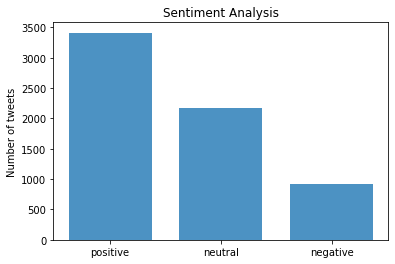

In [112]:
# Plotting the Polarity Scores
plt.bar(range(len(y)), height = y, width = 0.75, align="center",alpha = 0.8)

plt.xticks(range(len(y)), ["positive", "neutral", "negative"])

plt.title("Sentiment Analysis")

plt.ylabel("Number of tweets")

plt.show()

### Custom Sentiment Analyser

In [249]:
# creating a tmporary label func
def tmp_label_data(data):
    if data in pos_lst:
        return "pos"
    elif data in neg_lst:
        return "neg"
    elif data in neu_lst:
        return "neu"

# creating the labels
pos_lst = df[df.sentiment > 0]["sentiment"].to_list()

neg_lst = df[df.sentiment < 0]["sentiment"].to_list()

neu_lst = df[df.sentiment == 0]["sentiment"].to_list()

df["labels"] = df.sentiment.apply(lambda x : tmp_label_data(x))
df["labels"][:10]

0    pos
1    pos
2    pos
3    neg
4    neu
5    neu
6    pos
7    pos
8    pos
9    pos
Name: labels, dtype: object

In [268]:
# labeling the data
classes = ["pos", "neu", "neg"]

train_data = df["final"][:80]
train_labels = df["labels"][:80]

test_data = df["final"][80:96]
test_labels = df["labels"][80:96]

train_data = train_data.apply(str_lst)
test_data = test_data.apply(str_lst)

In [258]:
# testing
for x in zip(test_data[:3], test_labels[:3]):
    print(x)

('Last full Premier League season Martial clear Rashford debate wasnt French media agenda would httpstcoZzzlBpFzJx', 'pos')
('year winter break introduced four Premier League teams European finals Following seas httpstcobTftSBvY0Q', 'neu')
('know plays trashy team definitely one best players Premier League httpstcotpdz2KJiZY', 'pos')


In [189]:
# creating a Navie Bayes model
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)

In [263]:
# Obtaining the test and train vectors
train_vectors = vectorizer.fit_transform(train_data)
test_vectors = vectorizer.transform(test_data)

In [264]:
# fitting a model
nb = MultinomialNB()
nb.fit(train_vectors, train_labels).score(test_vectors, test_labels)

0.5625

In [265]:
## --- Model Assement ---
print("Navie Bayes")
print(classification_report(test_labels, nb.predict(test_vectors)))
print(confusion_matrix(test_labels, nb.predict(test_vectors)))

predicted = cross_val_predict(nb, train_vectors, train_labels, cv=10)
print(f"Cross validation : {accuracy_score(train_labels, predicted)}")

Navie Bayes
              precision    recall  f1-score   support

         neg       0.00      0.00      0.00         2
         neu       0.00      0.00      0.00         4
         pos       0.60      0.90      0.72        10

    accuracy                           0.56        16
   macro avg       0.20      0.30      0.24        16
weighted avg       0.38      0.56      0.45        16

[[0 0 2]
 [0 0 4]
 [0 1 9]]
Cross validation : 0.6625


## Named Entity Recognition

### Global  Variables

In [5]:
df = pd.read_csv("../data/tweets.csv")

df = df.drop(df.columns[0], axis=1)

In [43]:
stanford_dir = '../data/stanford-ner-4.2.0/stanford-ner-2020-11-17/'
jarfile = stanford_dir + 'stanford-ner.jar'
modelfile = stanford_dir + 'classifiers/english.all.3class.distsim.crf.ser.gz'

st = StanfordNERTagger(model_filename=modelfile, path_to_jar=jarfile)

In [47]:
## recognizing sample sentence 
tmp_sent = str_lst(df.final[0])

st.tag(tmp_sent.split())

[('Alisson', 'PERSON'),
 ('Becker', 'PERSON'),
 ('Alex', 'PERSON'),
 ('OxladeChamberlain', 'PERSON'),
 ('Declared', 'O'),
 ('Fit', 'O'),
 ('Weekend', 'O'),
 ('Premier', 'O'),
 ('League', 'O'),
 ('Game', 'O'),
 ('Fulh', 'O'),
 ('httpstcoBDMJzzufEb', 'O')]

In [75]:
tweets = df["final"].apply(str_lst).to_list()

# tweets[:5]

# getting all the entities
entities = []
for index,tweet in enumerate(tweets[:500]):
    lst_tags = st.tag(tweet.split()) 
    if lst_tags : print("Obtained Tags!")
    for tup in lst_tags:
        if (tup[1] != "O"):
            entities.append(tup)
    print(f"{index} iterations completed!")
    print("---------------------------------")
    
print("END")

Obtained Tags!
0 iterations completed!
---------------------------------
Obtained Tags!
1 iterations completed!
---------------------------------
Obtained Tags!
2 iterations completed!
---------------------------------
Obtained Tags!
3 iterations completed!
---------------------------------
Obtained Tags!
4 iterations completed!
---------------------------------
Obtained Tags!
5 iterations completed!
---------------------------------
Obtained Tags!
6 iterations completed!
---------------------------------
Obtained Tags!
7 iterations completed!
---------------------------------
Obtained Tags!
8 iterations completed!
---------------------------------
Obtained Tags!
9 iterations completed!
---------------------------------
Obtained Tags!
10 iterations completed!
---------------------------------
Obtained Tags!
11 iterations completed!
---------------------------------
Obtained Tags!
12 iterations completed!
---------------------------------
Obtained Tags!
13 iterations completed!
--------

Obtained Tags!
111 iterations completed!
---------------------------------
Obtained Tags!
112 iterations completed!
---------------------------------
Obtained Tags!
113 iterations completed!
---------------------------------
Obtained Tags!
114 iterations completed!
---------------------------------
Obtained Tags!
115 iterations completed!
---------------------------------
Obtained Tags!
116 iterations completed!
---------------------------------
Obtained Tags!
117 iterations completed!
---------------------------------
Obtained Tags!
118 iterations completed!
---------------------------------
Obtained Tags!
119 iterations completed!
---------------------------------
Obtained Tags!
120 iterations completed!
---------------------------------
Obtained Tags!
121 iterations completed!
---------------------------------
Obtained Tags!
122 iterations completed!
---------------------------------
Obtained Tags!
123 iterations completed!
---------------------------------
Obtained Tags!
124 iterat

Obtained Tags!
221 iterations completed!
---------------------------------
Obtained Tags!
222 iterations completed!
---------------------------------
Obtained Tags!
223 iterations completed!
---------------------------------
Obtained Tags!
224 iterations completed!
---------------------------------
Obtained Tags!
225 iterations completed!
---------------------------------
Obtained Tags!
226 iterations completed!
---------------------------------
Obtained Tags!
227 iterations completed!
---------------------------------
Obtained Tags!
228 iterations completed!
---------------------------------
Obtained Tags!
229 iterations completed!
---------------------------------
Obtained Tags!
230 iterations completed!
---------------------------------
Obtained Tags!
231 iterations completed!
---------------------------------
Obtained Tags!
232 iterations completed!
---------------------------------
Obtained Tags!
233 iterations completed!
---------------------------------
Obtained Tags!
234 iterat

Obtained Tags!
331 iterations completed!
---------------------------------
Obtained Tags!
332 iterations completed!
---------------------------------
Obtained Tags!
333 iterations completed!
---------------------------------
Obtained Tags!
334 iterations completed!
---------------------------------
Obtained Tags!
335 iterations completed!
---------------------------------
Obtained Tags!
336 iterations completed!
---------------------------------
Obtained Tags!
337 iterations completed!
---------------------------------
Obtained Tags!
338 iterations completed!
---------------------------------
Obtained Tags!
339 iterations completed!
---------------------------------
Obtained Tags!
340 iterations completed!
---------------------------------
Obtained Tags!
341 iterations completed!
---------------------------------
Obtained Tags!
342 iterations completed!
---------------------------------
Obtained Tags!
343 iterations completed!
---------------------------------
Obtained Tags!
344 iterat

Obtained Tags!
441 iterations completed!
---------------------------------
Obtained Tags!
442 iterations completed!
---------------------------------
Obtained Tags!
443 iterations completed!
---------------------------------
Obtained Tags!
444 iterations completed!
---------------------------------
Obtained Tags!
445 iterations completed!
---------------------------------
Obtained Tags!
446 iterations completed!
---------------------------------
Obtained Tags!
447 iterations completed!
---------------------------------
Obtained Tags!
448 iterations completed!
---------------------------------
Obtained Tags!
449 iterations completed!
---------------------------------
Obtained Tags!
450 iterations completed!
---------------------------------
Obtained Tags!
451 iterations completed!
---------------------------------
Obtained Tags!
452 iterations completed!
---------------------------------
Obtained Tags!
453 iterations completed!
---------------------------------
Obtained Tags!
454 iterat

In [76]:
len(entities)

1386

In [77]:
# creating a dataframe of entities
df_entities = pd.DataFrame(entities)
df_entities.columns = ["word", "ner"]

df_entities.head()

,word,ner
0,Alisson,PERSON
1,Becker,PERSON
2,Alex,PERSON
3,OxladeChamberlain,PERSON
4,EPL,ORGANIZATION


In [84]:
## computing the no of occurences uding Counter module
# by organization 
organizations = df_entities[df_entities["ner"].str.contains("ORGANIZATION")]

cnt = Counter(organizations["word"])
cnt.most_common(10)

[('League', 163),
 ('Premier', 160),
 ('United', 37),
 ('Manchester', 30),
 ('Leeds', 24),
 ('West', 17),
 ('Fernandes', 17),
 ('Bruno', 16),
 ('Ham', 12),
 ('Liverpool', 9)]

In [83]:
# by person
persons = df_entities[df_entities["ner"].str.contains("PERSON")]

cnt = Counter(persons["word"])
cnt.most_common(10)

[('Bruno', 65),
 ('Fernandes', 49),
 ('Mourinho', 19),
 ('Jose', 16),
 ('Solskjaer', 12),
 ('Woodward', 11),
 ('Ed', 10),
 ('Ole', 8),
 ('Kevin', 7),
 ('De', 7)]

In [87]:
# by locations
locations = df_entities[df_entities["ner"].str.contains("LOCATION")]

cnt = Counter(locations["word"])
cnt.most_common(10)

[('England', 9),
 ('Leipzig', 3),
 ('West', 3),
 ('Ham', 3),
 ('Elland', 3),
 ('Road', 3),
 ('Kazakhstan', 1),
 ('NewsNowUK', 1),
 ('Utd', 1),
 ('Stadium', 1)]

### Combining NER & Sentiment Analysis

In [17]:
# df.head()

In [22]:
tweets = df["final"].apply(str_lst)

tweets[:5]

0    Alisson Becker Alex OxladeChamberlain Declared...
1    EPL TONIGHT Leeds West Ham hope bounce back Pr...
2    Bruno Fernandes Premier League POTM awards Kev...
3    seen lot negative comments Meslier actually th...
4    Jose Mourinho Premier League manager month Nov...
Name: final, dtype: object

In [41]:
# calculate the avg sentiment of liverpool
sub_set = df[tweets.str.contains("Liverpool")]

avg_senti = np.mean(sub_set["sentiment"])
avg_senti

0.2855615384615385

In [38]:
# calculate the avg sentiment of chelsea
sub_set = df[tweets.str.contains("Chelsea")]

avg_senti = np.mean(sub_set["sentiment"])
avg_senti

0.22571333333333332

In [42]:
# calculate the avg sentiment of arsenal
sub_set = df[tweets.str.contains("Arsenal")]

avg_senti = np.mean(sub_set["sentiment"])
avg_senti

0.16718189473684214